# **Atividade Prática - Avaliação Comparativa de Classificadores**

Equipe:
* Beatriz Andrade de Miranda - bam2@cin.ufpe.br
* Camila Siqueira Lins - csl2@cin.ufpe.br
* Luisa Cavalcante - lncc@cin.ufpe.br
* Nicolly Lira Albuquerque - nla@cin.ufpe.br


#Importação de bibliotecas

In [ ]:
!pip install ucimlrepo

In [ ]:
!pip install sklvq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 4.6 MB/s eta 0:00:00


In [ ]:
#Base de dados
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Pré-processamento
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Algorítmos para criação de modelos
from sklearn.svm import SVC
from sklvq import GLVQ

#Otimização
from sklearn.model_selection import GridSearchCV

#Métricas de avaliação
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay

#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#Carregamento de base

In [ ]:
# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets

In [ ]:
X.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

## Análise Exploratória dos Dados

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
dtypes: float64(11)
memory usage: 558.5 KB


In [ ]:
X.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


In [ ]:
y.value_counts()

,count
quality,
6,2836
5,2138
7,1079
4,216
8,193
3,30
9,5


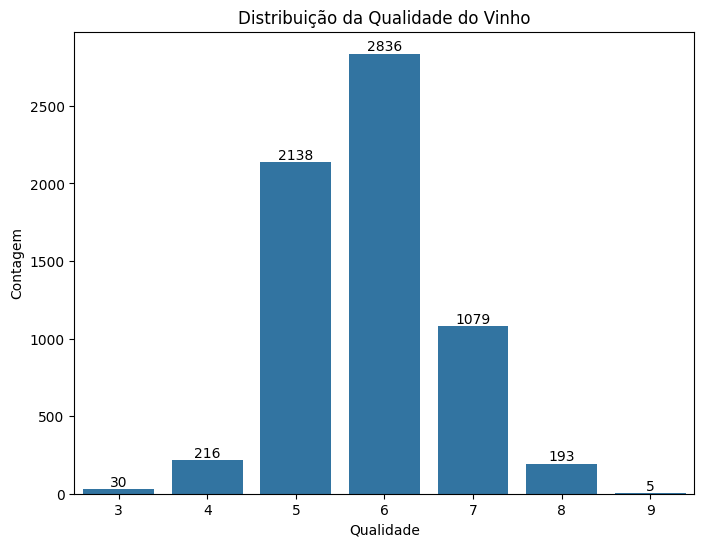

In [ ]:
y_flat = y.values.ravel()
y_df = pd.Series(y_flat, name='quality')

plt.figure(figsize=(8, 6))
ax = sns.countplot(x=y_df)
plt.title('Distribuição da Qualidade do Vinho')
plt.xlabel('Qualidade')
plt.ylabel('Contagem')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')
plt.show()

* Dados estão desbalanceados
* A nota 6 é a mais frequente, seguida pela nota 5 e 7, enquanto as notas extremas (3 e 9) são raras.

In [ ]:
# Quantidade de valores nulos
X.isnull().sum()

,0
fixed_acidity,0
volatile_acidity,0
citric_acid,0
residual_sugar,0
chlorides,0
free_sulfur_dioxide,0
total_sulfur_dioxide,0
density,0
pH,0
sulphates,0


Sem valores nulos nos dados

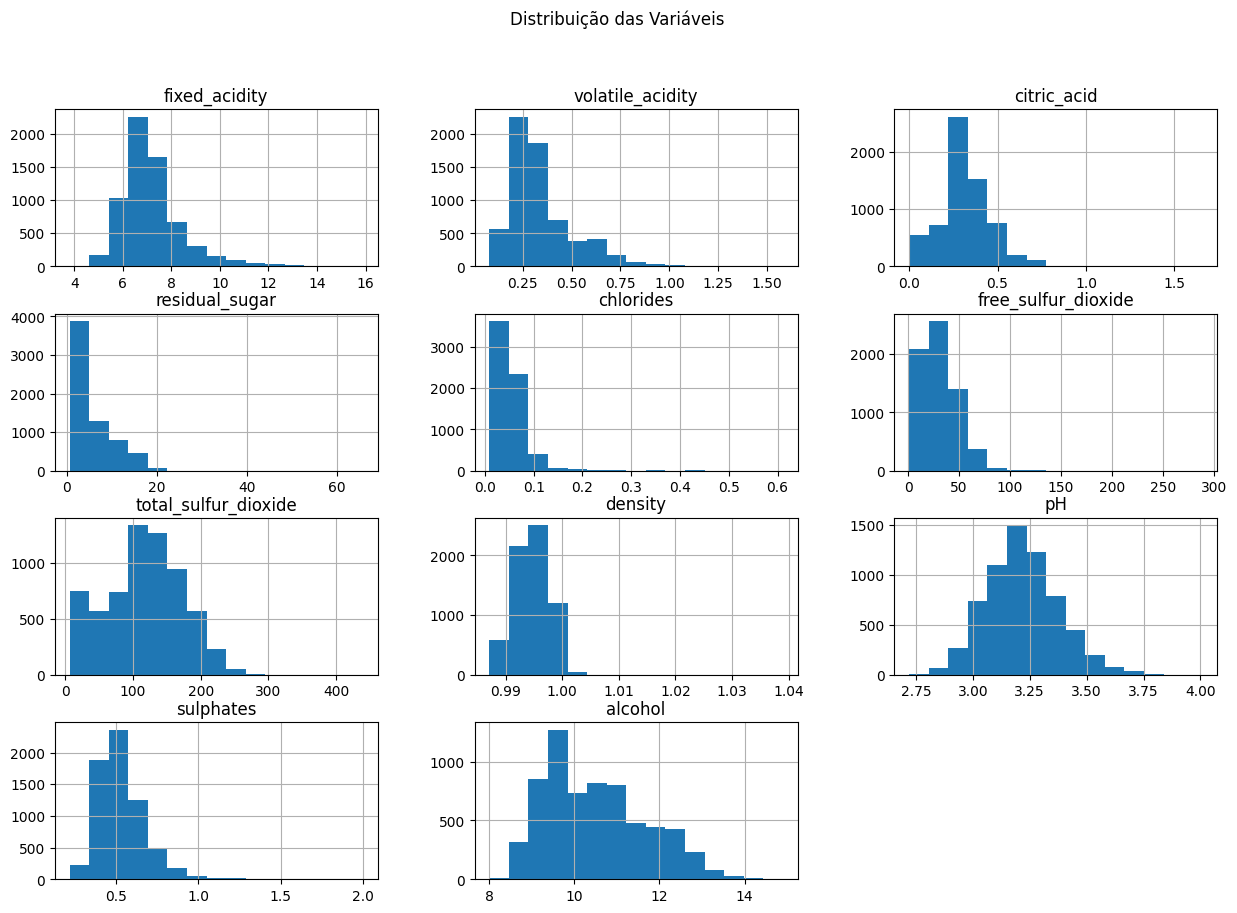

In [ ]:
X.hist(bins=15, figsize=(15, 10))
plt.suptitle('Distribuição das Variáveis')
plt.show()

* A maioria das variáveis, como residual_sugar, chlorides, free_sulfur_dioxide e total_sulfur_dioxide, possuem distribuições assimétricas, com uma cauda longa à direita, indicando valores mais elevados em poucas observações.
* Variáveis como fixed_acidity, density, pH e alcohol parecem ter distribuições mais próximas da normalidade, embora ainda com alguma assimetria.

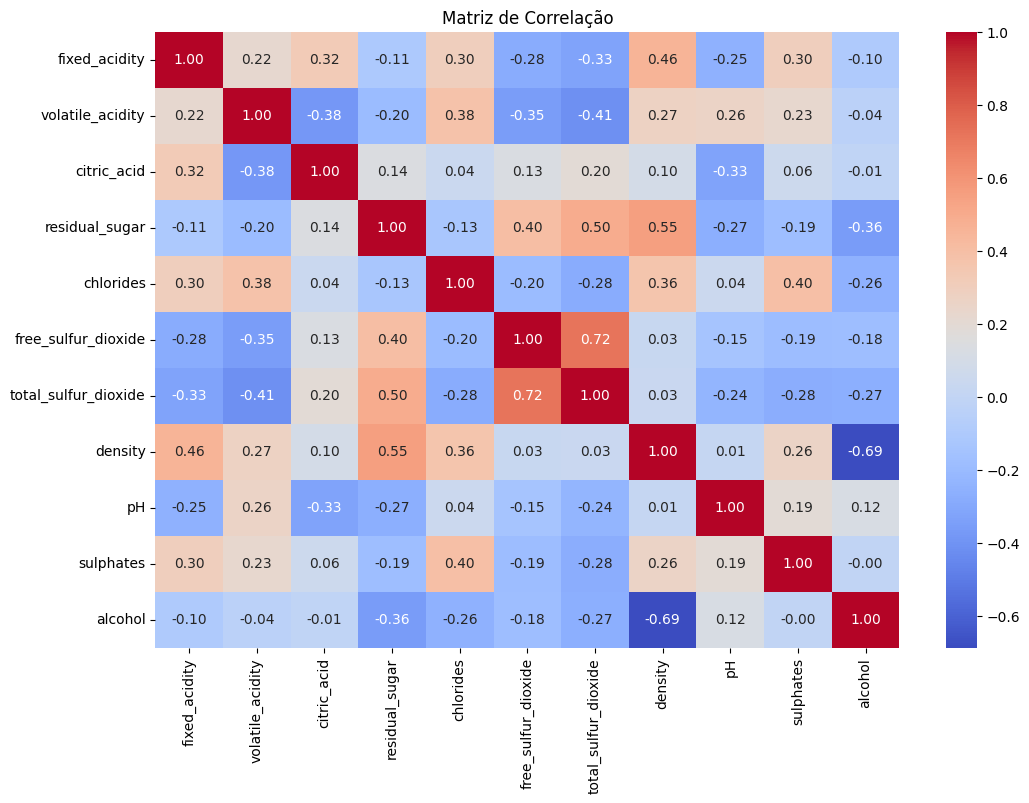

In [ ]:
corr_matrix = X.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

* As correlações entre as variáveis são geralmente baixas, indicando pouca multicolinearidade.
* density e alcohol possuem uma correlação negativa significativa (-0.69), o que indica que vinhos com maior teor alcoólico tendem a ter menor densidade.
* total_sulfur_dioxide e free_sulfur_dioxide estão positivamente correlacionados (0.72), o que faz sentido, pois ambos estão relacionados à presença de dióxido de enxofre.
* Algumas variáveis como residual_sugar e density também possuem uma correlação moderada (0.55), o que sugere que vinhos com mais açúcar residual tendem a ter maior densidade.

<Figure size 1500x1000 with 0 Axes>

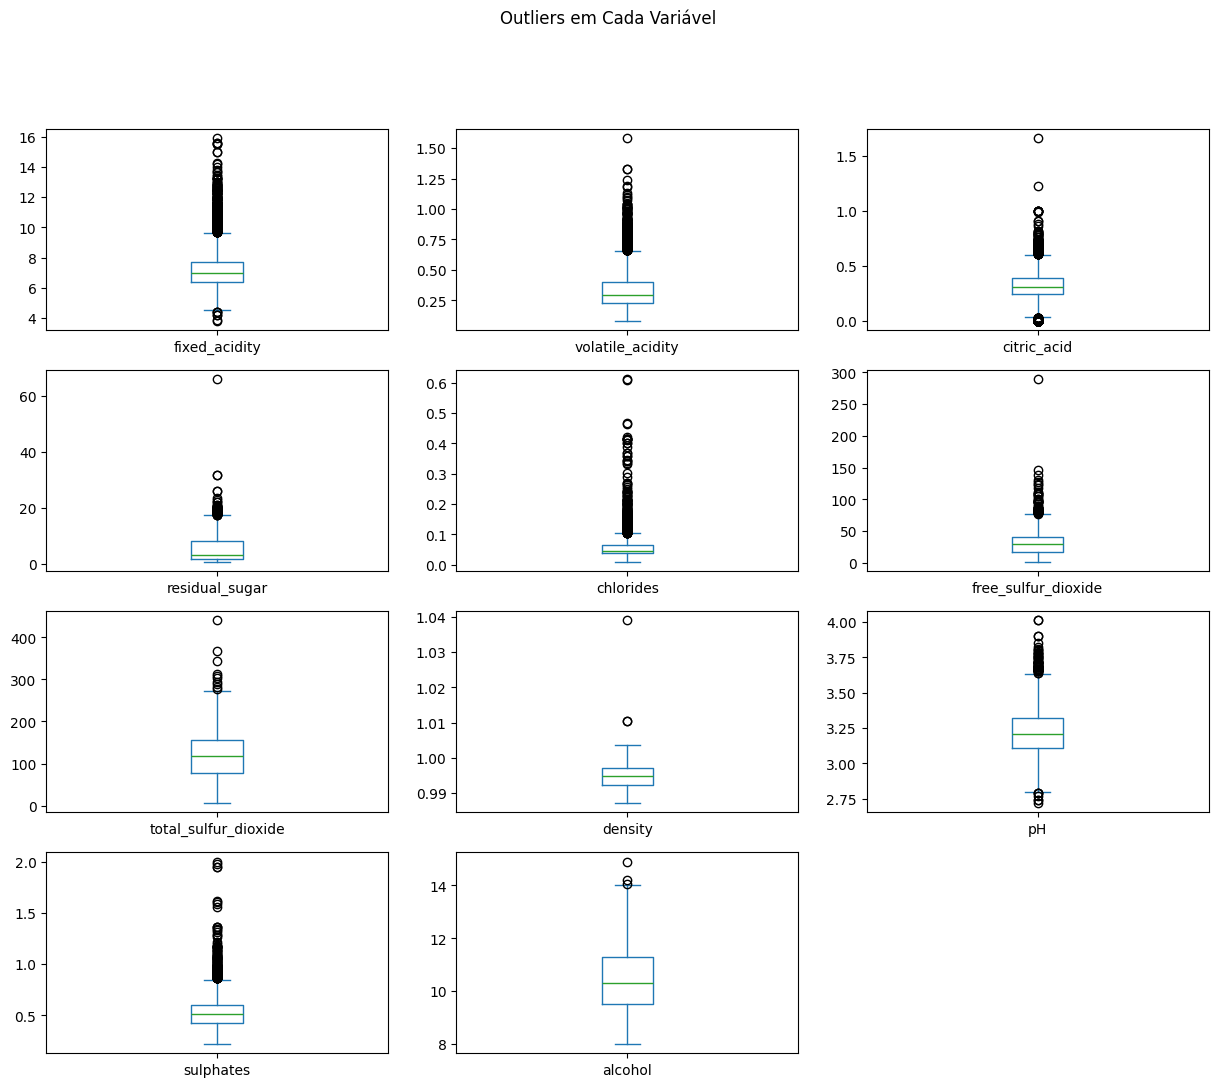

In [ ]:
plt.figure(figsize=(15, 10))
X.plot(kind='box', subplots=True, layout=(4, 3), figsize=(15, 12), sharex=False, sharey=False)
plt.suptitle('Outliers em Cada Variável')
plt.show()

#Pre-processamento

### Criação de faixas

In [ ]:
y['quality'] = y['quality'].replace({3: '3-4'})
y['quality'] = y['quality'].replace({4: '3-4'})
y['quality'] = y['quality'].replace({5: '5-6'})
y['quality'] = y['quality'].replace({6: '5-6'})
y['quality'] = y['quality'].replace({7: '7'})
y['quality'] = y['quality'].replace({8: '8-9'})
y['quality'] = y['quality'].replace({9: '8-9'})

<ipython-input-8-5ae218d91d3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['quality'] = y['quality'].replace({3: '3-4'})
<ipython-input-8-5ae218d91d3f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['quality'] = y['quality'].replace({4: '3-4'})
<ipython-input-8-5ae218d91d3f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [ ]:
y.value_counts()

,count
quality,
5-6,4974
7,1079
3-4,246
8-9,198


### Separação de conjuntos

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state = 10)

###Balanceamento de classes

In [ ]:
smote = SMOTE(random_state=42, k_neighbors = 4)
X_trainOver, y_trainOver = smote.fit_resample(X_train, y_train)
X_testOver, y_testOver = smote.fit_resample(X_test, y_test)
X_validOver, y_validOver = smote.fit_resample(X_valid, y_valid)

In [ ]:
y_trainOver.value_counts()

,count
quality,
3-4,2822
5-6,2822
7,2822
8-9,2822


In [ ]:
len(X_testOver)

4872

In [ ]:
len(y_testOver)

4872

In [ ]:
y_validOver.value_counts()

,count
quality,
3-4,934
5-6,934
7,934
8-9,934


### Escalonamento

In [ ]:
scaler = MinMaxScaler()

normalized_train= scaler.fit_transform(X_trainOver)
normalized_test= scaler.fit_transform(X_testOver)
normalized_valid= scaler.fit_transform(X_validOver)

X_trainScaled = pd.DataFrame(normalized_train, columns=X.columns)
X_testScaled = pd.DataFrame(normalized_test, columns=X.columns)
X_validScaled = pd.DataFrame(normalized_valid, columns=X.columns)

In [ ]:
X_trainScaled.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,0.214876,0.072398,0.150602,0.010753,0.079734,0.069444,0.274194,0.072903,0.385827,0.123596,0.449275
1,0.438017,0.235294,0.253012,0.016897,0.081395,0.027778,0.027650,0.130955,0.346457,0.185393,0.492754
2,0.231405,0.081448,0.228916,0.012289,0.038206,0.093750,0.244240,0.082353,0.401575,0.185393,0.492754
3,0.272727,0.280543,0.210843,0.181260,0.058140,0.086806,0.152074,0.134426,0.338583,0.039326,0.521739
4,0.280992,0.135747,0.228916,0.208909,0.081395,0.187500,0.433180,0.207715,0.275591,0.123596,0.144928


#Algoritmos

## KNN

In [ ]:
print("Dimensões de X_trainScaled:", X_trainScaled.shape)
print("Dimensões de y_trainOver:", y_trainOver.shape)
print("Dimensões de X_testScaled:", X_testScaled.shape)
print("Dimensões de y_test:", y_testOver.shape)


Dimensões de X_trainScaled: (11288, 11)
Dimensões de y_trainOver: (11288, 1)
Dimensões de X_testScaled: (4872, 11)
Dimensões de y_test: (4872, 1)


Ver validação

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
from sklearn.preprocessing import LabelEncoder
plt.rcParams['figure.figsize'] = [16, 10]

# Definindo o espaço de busca para o valor de k e a métrica de distância
param_grid = {
    'n_neighbors': range(5, 50),  # valores de k de 5 a 49
    'metric': ["euclidean", "manhattan"]  # métricas de distância
}

# Configurando validação cruzada com 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Lista para armazenar os resultados
results = []
label_encoder = LabelEncoder()
# Loop para buscar a melhor combinação de parâmetros
for k in param_grid['n_neighbors']:
    for metric in param_grid['metric']:
        print(f"Treinando para k={k} e métrica de distância {metric}")
        fold_results = {'accuracy': [], 'recall': [], 'precision': [], 'f1': [], 'roc_auc': []}

        # Validação cruzada
        for train_index, test_index in kf.split(X_trainScaled):
            X_train_fold, X_test_fold = X_trainScaled.iloc[train_index], X_trainScaled.iloc[test_index]
            y_train_fold, y_test_fold = y_trainOver.iloc[train_index], y_trainOver.iloc[test_index]

            # Treinamento do modelo
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
            knn.fit(X_train_fold, y_train_fold)

            # Previsões e cálculo de métricas para cada fold
            y_pred_fold = knn.predict(X_test_fold)
            fold_results['accuracy'].append(accuracy_score(y_test_fold, y_pred_fold))
            fold_results['recall'].append(recall_score(y_test_fold, y_pred_fold, average='macro'))
            fold_results['precision'].append(precision_score(y_test_fold, y_pred_fold, average='macro'))
            fold_results['f1'].append(f1_score(y_test_fold, y_pred_fold, average='macro'))

            try:
                # Vamos querer codificar mesmo?
                y_test_fold_encoded = label_encoder.fit_transform(y_test_fold)
                fold_results['roc_auc'].append(
                    roc_auc_score(y_test_fold_encoded, knn.predict_proba(X_test_fold), multi_class='ovr')
                )
            except ValueError:
                fold_results['roc_auc'].append(np.nan)

        results.append({
            'n_neighbors': k,
            'metric': metric,
            'accuracy': np.mean(fold_results['accuracy']),
            'recall': np.mean(fold_results['recall']),
            'precision': np.mean(fold_results['precision']),
            'f1': np.mean(fold_results['f1']),
            'roc_auc': np.nanmean(fold_results['roc_auc'])  # Calcula média ignorando NaN
        })

# Convertendo os resultados em um DataFrame
results_knn = pd.DataFrame(results)

# Exibindo as 5 melhores combinações de parâmetros
print(results_knn.sort_values(by='accuracy', ascending=False).head(5))


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
results_knn.to_csv('results_knn.csv')

In [ ]:
# Encontrando o melhor conjunto de parâmetros com base na acurácia, ou outra métrica de preferência
best_k = results_knn.loc[results_knn['accuracy'].idxmax(), 'n_neighbors']
best_metric = results_knn.loc[results_knn['accuracy'].idxmax(), 'metric']
best_score = results_knn['accuracy'].max()

print(f"Melhor número de vizinhos (k): {best_k}")
print(f"Melhor métrica de distância: {best_metric}")
print(f"Melhor acurácia: {best_score}")

Melhor número de vizinhos (k): 5
Melhor métrica de distância: manhattan
Melhor acurácia: 0.8669372569712731

## Arvore de decisão

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, make_scorer
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
# Definindo o espaço de busca para os hiperparâmetros da árvore de decisão
param_grid = {
    'max_depth': [3, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Configurando validação cruzada com 5 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)
label_encoder = LabelEncoder()
# Lista para armazenar os resultados
results = []

# Loop para buscar a melhor combinação de parâmetros
for max_depth in param_grid['max_depth']:
    for min_samples_split in param_grid['min_samples_split']:
        for min_samples_leaf in param_grid['min_samples_leaf']:
            for criterion in param_grid['criterion']:
                fold_results = {'accuracy': [], 'recall': [], 'precision': [], 'f1': [], 'roc_auc': []}

                # Validação cruzada
                for train_index, test_index in kf.split(X_trainScaled):
                    X_train_fold, X_test_fold = X_trainScaled.iloc[train_index], X_trainScaled.iloc[test_index]
                    y_train_fold, y_test_fold = y_trainOver.iloc[train_index], y_trainOver.iloc[test_index]

                    # Treinamento do modelo com os parâmetros específicos
                    dt = DecisionTreeClassifier(
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        criterion=criterion,
                        random_state=42
                    )
                    dt.fit(X_train_fold, y_train_fold)

                    # Previsões e cálculo de métricas para cada fold
                    y_pred_fold = dt.predict(X_test_fold)
                    fold_results['accuracy'].append(accuracy_score(y_test_fold, y_pred_fold))
                    fold_results['recall'].append(recall_score(y_test_fold, y_pred_fold, average='macro'))
                    fold_results['precision'].append(precision_score(y_test_fold, y_pred_fold, average='macro'))
                    fold_results['f1'].append(f1_score(y_test_fold, y_pred_fold, average='macro'))

                    try:
                        y_test_fold_encoded = LabelEncoder().fit_transform(y_test_fold)
                        fold_results['roc_auc'].append(
                            roc_auc_score(y_test_fold_encoded, dt.predict_proba(X_test_fold), multi_class='ovr')
                        )
                    except ValueError:
                        fold_results['roc_auc'].append(np.nan)

                # Armazenando os resultados médios para cada combinação de hiperparâmetros
                results.append({
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'criterion': criterion,
                    'accuracy': np.mean(fold_results['accuracy']),
                    'recall': np.mean(fold_results['recall']),
                    'precision': np.mean(fold_results['precision']),
                    'f1': np.mean(fold_results['f1']),
                    'roc_auc': np.nanmean(fold_results['roc_auc'])  # Ignora NaN
                })

# Convertendo os resultados em um DataFrame
results_dt = pd.DataFrame(results)

# Exibindo as 5 melhores combinações de parâmetros
print(results_dt.sort_values(by='accuracy', ascending=False).head(5))


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [ ]:
results_dt.to_csv('results_dt.csv')

In [ ]:
# Encontrando o melhor conjunto de parâmetros com base na acurácia, ou outra métrica de preferência
best_max_depth= results_dt.loc[results_dt['accuracy'].idxmax(), 'max_depth']
best_min_samples_split = results_dt.loc[results_dt['accuracy'].idxmax(), 'min_samples_split']
best_min_samples_leaf = results_dt.loc[results_dt['accuracy'].idxmax(), 'min_samples_leaf']
best_criterion= results_dt.loc[results_dt['accuracy'].idxmax(), 'criterion']
best_score = results_dt['accuracy'].max()

print(f"Melhor profundidade máxima: {best_max_depth}")
print(f"Melhor menor quantidade possível de divisões: {best_min_samples_split}")
print(f"Melhor menor quantidade de folhas: {best_min_samples_leaf}")
print(f"Melhor criterio de impureza: {best_criterion}")
print(f"Melhor acurácia: {best_score}")




Melhores parâmetros: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Acurácia média de validação (CV): 0.8468
Acurácia no conjunto de validação: 0.3638


## Learning Vector Quantization (LQV)

In [ ]:
from sklvq import GLVQ
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

param_grid_glvq = {
    'distance_type': ['squared-euclidean', 'euclidean'],
    'activation_type': ['identity'],
    'activation_params': [{'beta': 1}, {'beta': 2}, {'beta': 3}],
    'solver_type': ['steepest-gradient-descent', 'adam'],
    'solver_params': [{'max_runs': 20, 'step_size': 0.1}, {'max_runs': 50, 'step_size': 0.01}]
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

results = []
label_encoder = LabelEncoder()

for distance_type in param_grid_glvq['distance_type']:
    for activation_type in param_grid_glvq['activation_type']:
        for activation_params in param_grid_glvq['activation_params']:
            for solver_type in param_grid_glvq['solver_type']:
                for solver_params in param_grid_glvq['solver_params']:

                    if activation_type == 'identity':
                        model_params = {
                            'distance_type': distance_type,
                            'activation_type': activation_type,
                            'solver_type': solver_type,
                            'solver_params': solver_params
                        }
                    else:
                        continue

                    print(f"Treinando com distance_type={distance_type}, activation_type={activation_type}, "
                          f"activation_params={activation_params if activation_type != 'identity' else 'N/A'}, "
                          f"solver_type={solver_type}, solver_params={solver_params}")

                    fold_results = {'accuracy': [], 'recall': [], 'precision': [], 'f1': [], 'roc_auc': []}

                    for train_index, test_index in kf.split(X_trainScaled):
                        X_train_fold, X_test_fold = X_trainScaled.iloc[train_index], X_trainScaled.iloc[test_index]
                        y_train_fold, y_test_fold = y_trainOver.iloc[train_index], y_trainOver.iloc[test_index]

                        glvq = GLVQ(**model_params)
                        glvq.fit(X_train_fold, y_train_fold.values.ravel())

                        y_pred_fold = glvq.predict(X_test_fold)
                        fold_results['accuracy'].append(accuracy_score(y_test_fold, y_pred_fold))
                        fold_results['recall'].append(recall_score(y_test_fold, y_pred_fold, average='macro'))
                        fold_results['precision'].append(precision_score(y_test_fold, y_pred_fold, average='macro'))
                        fold_results['f1'].append(f1_score(y_test_fold, y_pred_fold, average='macro'))

                        try:
                            y_test_fold_encoded = label_encoder.fit_transform(y_test_fold)
                            fold_results['roc_auc'].append(
                                roc_auc_score(y_test_fold_encoded, glvq.predict_proba(X_test_fold), multi_class='ovr')
                            )
                        except ValueError:
                            fold_results['roc_auc'].append(np.nan)

                    results.append({
                        'distance_type': distance_type,
                        'activation_type': activation_type,
                        'activation_params': activation_params if activation_type != 'identity' else 'N/A',
                        'solver_type': solver_type,
                        'solver_params': solver_params,
                        'accuracy': np.mean(fold_results['accuracy']),
                        'recall': np.mean(fold_results['recall']),
                        'precision': np.mean(fold_results['precision']),
                        'f1': np.mean(fold_results['f1']),
                        'roc_auc': np.nanmean(fold_results['roc_auc'])  # Ignora NaN
                    })

results_glvq = pd.DataFrame(results)
print(results_glvq.sort_values(by='accuracy', ascending=False).head(5))

Treinando com distance_type=squared-euclidean, activation_type=identity, activation_params=N/A, solver_type=steepest-gradient-descent, solver_params={'max_runs': 20, 'step_size': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Treinando com distance_type=squared-euclidean, activation_type=identity, activation_params=N/A, solver_type=steepest-gradient-descent, solver_params={'max_runs': 50, 'step_size': 0.01}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Treinando com distance_type=squared-euclidean, activation_type=identity, activation_params=N/A, solver_type=adam, solver_params={'max_runs': 20, 'step_size': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was ex

Treinando com distance_type=squared-euclidean, activation_type=identity, activation_params=N/A, solver_type=adam, solver_params={'max_runs': 50, 'step_size': 0.01}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Treinando com distance_type=squared-euclidean, activation_type=identity, activation_params=N/A, solver_type=steepest-gradient-descent, solver_params={'max_runs': 20, 'step_size': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Treinando com distance_type=squared-euclidean, activation_type=identity, activation_params=N/A, solver_type=steepest-gradient-descent, solver_params={'max_runs': 50, 'step_size': 0.01}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Treinando com distance_type=squared-euclidean, activation_type=identity, activation_params=N/A, solver_type=adam, solver_params={'max_runs': 20, 'step_size': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was ex

Treinando com distance_type=squared-euclidean, activation_type=identity, activation_params=N/A, solver_type=adam, solver_params={'max_runs': 50, 'step_size': 0.01}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Treinando com distance_type=squared-euclidean, activation_type=identity, activation_params=N/A, solver_type=steepest-gradient-descent, solver_params={'max_runs': 20, 'step_size': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Treinando com distance_type=squared-euclidean, activation_type=identity, activation_params=N/A, solver_type=steepest-gradient-descent, solver_params={'max_runs': 50, 'step_size': 0.01}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Treinando com distance_type=squared-euclidean, activation_type=identity, activation_params=N/A, solver_type=adam, solver_params={'max_runs': 20, 'step_size': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: 

Treinando com distance_type=squared-euclidean, activation_type=identity, activation_params=N/A, solver_type=adam, solver_params={'max_runs': 50, 'step_size': 0.01}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Treinando com distance_type=euclidean, activation_type=identity, activation_params=N/A, solver_type=steepest-gradient-descent, solver_params={'max_runs': 20, 'step_size': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Treinando com distance_type=euclidean, activation_type=identity, activation_params=N/A, solver_type=steepest-gradient-descent, solver_params={'max_runs': 50, 'step_size': 0.01}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Treinando com distance_type=euclidean, activation_type=identity, activation_params=N/A, solver_type=adam, solver_params={'max_runs': 20, 'step_size': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: 

Treinando com distance_type=euclidean, activation_type=identity, activation_params=N/A, solver_type=adam, solver_params={'max_runs': 50, 'step_size': 0.01}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Treinando com distance_type=euclidean, activation_type=identity, activation_params=N/A, solver_type=steepest-gradient-descent, solver_params={'max_runs': 20, 'step_size': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Treinando com distance_type=euclidean, activation_type=identity, activation_params=N/A, solver_type=steepest-gradient-descent, solver_params={'max_runs': 50, 'step_size': 0.01}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Treinando com distance_type=euclidean, activation_type=identity, activation_params=N/A, solver_type=adam, solver_params={'max_runs': 20, 'step_size': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: 

Treinando com distance_type=euclidean, activation_type=identity, activation_params=N/A, solver_type=adam, solver_params={'max_runs': 50, 'step_size': 0.01}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

Treinando com distance_type=euclidean, activation_type=identity, activation_params=N/A, solver_type=steepest-gradient-descent, solver_params={'max_runs': 20, 'step_size': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Treinando com distance_type=euclidean, activation_type=identity, activation_params=N/A, solver_type=steepest-gradient-descent, solver_params={'max_runs': 50, 'step_size': 0.01}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Treinando com distance_type=euclidean, activation_type=identity, activation_params=N/A, solver_type=adam, solver_params={'max_runs': 20, 'step_size': 0.1}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 

Treinando com distance_type=euclidean, activation_type=identity, activation_params=N/A, solver_type=adam, solver_params={'max_runs': 50, 'step_size': 0.01}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

        distance_type activation_type activation_params  \
5   squared-euclidean        identity               N/A   
21          euclidean        identity               N/A   
1   squared-euclidean        identity               N/A   
9   squared-euclidean        identity               N/A   
7   squared-euclidean        identity               N/A   

                  solver_type                        solver_params  accuracy  \
5   steepest-gradient-descent  {'max_runs': 50, 'step_size': 0.01}  0.497079   
21  steepest-gradient-descent  {'max_runs': 50, 'step_size': 0.01}  0.489281   
1   steepest-gradient-descent  {'max_runs': 50, 'step_size': 0.01}  0.488929   
9   steepest-gradient-descent  {'max_runs': 50, 'step_size': 0.01}  0.486627   
7                        adam  {'max_runs': 50, 'step_size': 0.01}  0.481662   

      recall  precision        f1   roc_auc  
5   0.497143   0.482508  0.456757  0.745632  
21  0.489087   0.466986  0.440123  0.737335  
1   0.490102   0.492977  0

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
results_glvq.to_csv('results_lvq.csv')

In [ ]:
results_glvq

,distance_type,activation_type,activation_params,solver_type,solver_params,accuracy,recall,precision,f1,roc_auc
0,squared-euclidean,identity,N/A,steepest-gradient-descent,"{'max_runs': 20, 'step_size': 0.1}",0.473422,0.471373,0.488044,0.420815,0.756635
1,squared-euclidean,identity,N/A,steepest-gradient-descent,"{'max_runs': 50, 'step_size': 0.01}",0.488929,0.490102,0.492977,0.424013,0.745686
2,squared-euclidean,identity,N/A,adam,"{'max_runs': 20, 'step_size': 0.1}",0.410263,0.409729,0.467666,0.333307,0.742270
3,squared-euclidean,identity,N/A,adam,"{'max_runs': 50, 'step_size': 0.01}",0.473508,0.472164,0.489238,0.420775,0.750368
4,squared-euclidean,identity,N/A,steepest-gradient-descent,"{'max_runs': 20, 'step_size': 0.1}",0.447817,0.446514,0.467268,0.384336,0.759377
5,squared-euclidean,identity,N/A,steepest-gradient-descent,"{'max_runs': 50, 'step_size': 0.01}",0.497079,0.497143,0.482508,0.456757,0.745632
6,squared-euclidean,identity,N/A,adam,"{'max_runs': 20, 'step_size': 0.1}",0.345133,0.336838,0.281732,0.234668,0.734394
7,squared-euclidean,identity,N/A,adam,"{'max_runs': 50, 'step_size': 0.01}",0.481662,0.480497,0.477348,0.436141,0.756458
8,squared-euclidean,identity,N/A,steepest-gradient-descent,"{'max_runs': 20, 'step_size': 0.1}",0.459868,0.461959,0.506955,0.394264,0.759480
9,squared-euclidean,identity,N/A,steepest-gradient-descent,"{'max_runs': 50, 'step_size': 0.01}",0.486627,0.486479,0.478493,0.436924,0.746410


In [ ]:
results_glvq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   distance_type      24 non-null     object 
 1   activation_type    24 non-null     object 
 2   activation_params  24 non-null     object 
 3   solver_type        24 non-null     object 
 4   solver_params      24 non-null     object 
 5   accuracy           24 non-null     float64
 6   recall             24 non-null     float64
 7   precision          24 non-null     float64
 8   f1                 24 non-null     float64
 9   roc_auc            24 non-null     float64
dtypes: float64(5), object(5)
memory usage: 2.0+ KB


In [ ]:
best_params_glvq = results_glvq.loc[results_glvq['accuracy'].idxmax()]
best_distance_type = best_params_glvq['distance_type']
best_activation_type = best_params_glvq['activation_type']
best_activation_params = best_params_glvq['activation_params']
best_solver_type = best_params_glvq['solver_type']
best_solver_params = best_params_glvq['solver_params']
best_score = best_params_glvq['accuracy']

print(f"Melhor tipo de distância: {best_distance_type}")
print(f"Melhor tipo de ativação: {best_activation_type}")
print(f"Melhores parâmetros de ativação: {best_activation_params}")
print(f"Melhor tipo de solver: {best_solver_type}")
print(f"Melhores parâmetros de solver: {best_solver_params}")
print(f"Melhor acurácia: {best_score}")

if best_params_glvq['activation_type'] == 'identity':
    best_glvq_model = GLVQ(
        distance_type=best_params_glvq['distance_type'],
        activation_type=best_params_glvq['activation_type'],
        solver_type=best_params_glvq['solver_type'],
        solver_params=best_params_glvq['solver_params']
    )
else:
    best_glvq_model = GLVQ(
        distance_type=best_params_glvq['distance_type'],
        activation_type=best_params_glvq['activation_type'],
        activation_params=best_params_glvq['activation_params'],
        solver_type=best_params_glvq['solver_type'],
        solver_params=best_params_glvq['solver_params']
    )

best_glvq_model.fit(X_trainScaled, y_trainOver)

y_val_pred = best_glvq_model.predict(X_validScaled)
val_accuracy = accuracy_score(y_validOver, y_val_pred)
print(f"Acurácia no conjunto de validação: {val_accuracy:.4f}")
print("Desempenho no Conjunto de Validação:\n")
print(classification_report(y_validOver, y_val_pred, zero_division=1))

Melhor tipo de distância: squared-euclidean
Melhor tipo de ativação: identity
Melhores parâmetros de ativação: N/A
Melhor tipo de solver: steepest-gradient-descent
Melhores parâmetros de solver: {'max_runs': 50, 'step_size': 0.01}
Melhor acurácia: 0.4970791009429044


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Acurácia no conjunto de validação: 0.4307
Desempenho no Conjunto de Validação:

              precision    recall  f1-score   support

         3-4       0.75      0.35      0.48       934
         5-6       0.41      0.57      0.48       934
           7       0.34      0.08      0.12       934
         8-9       0.38      0.73      0.50       934

    accuracy                           0.43      3736
   macro avg       0.47      0.43      0.39      3736
weighted avg       0.47      0.43      0.39      3736



## Suport Vector Machine (SVM)

In [ ]:
for C in param_grid['C']:
    for kernel in param_grid['kernel']:
        for gamma in param_grid['gamma']:
          print(f"Treinando para C={C} e kernel {kernel} e gamma {gamma}")
          fold_results = {'accuracy': [], 'recall': [], 'precision': [], 'f1': [], 'roc_auc': []}

          # Validação cruzada
          for train_index, test_index in kf.split(X_trainScaled):
              X_train_fold, X_test_fold = X_trainScaled.iloc[train_index], X_trainScaled.iloc[test_index]
              y_train_fold, y_test_fold = y_trainOver.iloc[train_index], y_trainOver.iloc[test_index]

              svm = SVC(C=C, kernel=kernel,gamma =gamma,  probability=True)
              svm.fit(X_train_fold, y_train_fold)

              y_pred_fold = svm.predict(X_test_fold)
              fold_results['accuracy'].append(accuracy_score(y_test_fold, y_pred_fold))
              fold_results['recall'].append(recall_score(y_test_fold, y_pred_fold, average='macro'))
              fold_results['precision'].append(precision_score(y_test_fold, y_pred_fold, average='macro'))
              fold_results['f1'].append(f1_score(y_test_fold, y_pred_fold, average='macro'))

              try:
                  y_test_fold_encoded = label_encoder.fit_transform(y_test_fold)
                  fold_results['roc_auc'].append(
                      roc_auc_score(y_test_fold_encoded, svm.predict_proba(X_test_fold), multi_class='ovr')
                  )
              except ValueError:
                  fold_results['roc_auc'].append(np.nan)

          results.append({
              'C': C,
              'kernel': kernel,
              'gamma':gamma,
              'accuracy': np.mean(fold_results['accuracy']),
              'recall': np.mean(fold_results['recall']),
              'precision': np.mean(fold_results['precision']),
              'f1': np.mean(fold_results['f1']),
              'roc_auc': np.nanmean(fold_results['roc_auc'])
          })

# Convertendo os resultados em um DataFrame
results_svm = pd.DataFrame(results)

## Multilayer Perceptron (MLP)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [ ]:
faixa_para_classe = {
    '3-4': 0,
    '5-6': 1,
    '7': 2,
    '8-9': 3
}

y['quality'] = y['quality'].map(faixa_para_classe)
print(y['quality'].unique())

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
from sklearn.preprocessing import LabelEncoder
plt.rcParams['figure.figsize'] = [16, 10]

param_grid = {
    'hidden_layer_sizes': [(100,), (100, 100, 100), (50, 80, 100), (10, 10, 10)],
    'activation': ['relu', 'tanh', 'logistic', 'identity'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.1, 0.01, 0.005],
    'learning_rate': ['constant', 'adaptive']
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

results = []
label_encoder = LabelEncoder()

for hidden_layers in param_grid['hidden_layer_sizes']:
    for activation in param_grid['activation']:
        for solver in param_grid['solver']:
            for alpha in param_grid['alpha']:
                for learning_rate in param_grid['learning_rate']:
                    print(f"Treinando para hidden_layers={hidden_layers}, activation={activation}, solver={solver}, alpha={alpha}, learning_rate={learning_rate}")

                    fold_results = {'accuracy': [], 'recall': [], 'precision': [], 'f1': [], 'roc_auc': []}

                    for train_index, test_index in kf.split(X_trainScaled):
                        X_train_fold, X_test_fold = X_trainScaled.iloc[train_index], X_trainScaled.iloc[test_index]
                        y_train_fold, y_test_fold = y_trainOver.iloc[train_index], y_trainOver.iloc[test_index]

                        mlp = MLPClassifier(hidden_layer_sizes=hidden_layers, activation=activation, solver=solver, alpha=alpha, learning_rate=learning_rate, max_iter=300)  # Aumentando max_iter
                        mlp.fit(X_train_fold, y_train_fold.values.ravel())  # Ajustando formato do y


                        y_pred_fold = mlp.predict(X_test_fold)
                        fold_results['accuracy'].append(accuracy_score(y_test_fold, y_pred_fold))
                        fold_results['recall'].append(recall_score(y_test_fold, y_pred_fold, average='macro'))
                        fold_results['precision'].append(precision_score(y_test_fold, y_pred_fold, average='macro'))
                        fold_results['f1'].append(f1_score(y_test_fold, y_pred_fold, average='macro'))

                        try:
                            y_test_fold_encoded = label_encoder.fit_transform(y_test_fold)
                            fold_results['roc_auc'].append(
                                roc_auc_score(y_test_fold_encoded, mlp.predict_proba(X_test_fold), multi_class='ovr')
                            )
                        except ValueError:
                            fold_results['roc_auc'].append(np.nan)

                    results.append({
                        'hidden_layer_sizes': hidden_layers,
                        'activation': activation,
                        'solver': solver,
                        'alpha': alpha,
                        'learning_rate': learning_rate,
                        'accuracy': np.mean(fold_results['accuracy']),
                        'recall': np.mean(fold_results['recall']),
                        'precision': np.mean(fold_results['precision']),
                        'f1': np.mean(fold_results['f1']),
                        'roc_auc': np.nanmean(fold_results['roc_auc'])
                    })

results_mlp = pd.DataFrame(results)
print(results_mlp.sort_values(by='accuracy', ascending=False).head(5))

In [ ]:
results_mlp.to_csv('results_mlp.csv', index=False)

### Melhor modelo

## Comparação dos resultados dos algoritmos

In [ ]:
df_svm = pd.read_csv('https://drive.google.com/uc?id=18sW3cS6mq0fb2e64ZVwABQrzfMCkUFIA')
df_lqv = pd.read_csv('https://drive.google.com/uc?id=1ON0oLFAHIrXV5PikJ8XPWK5liyXi4wKl')
df_mlp = pd.read_csv('https://drive.google.com/uc?id=1Vnps7RpbT-rOt4aTcfd2FBlZdxo_xEhx')
df_dt = pd.read_csv('https://drive.google.com/uc?id=1c97i8CUwc2gHxhIq4THpDzOZ7RWbrfxY')
df_knn = pd.read_csv('https://drive.google.com/uc?id=1tQBAwOhbzN9NSBgmeyFUVjl2H1FT4gL1')

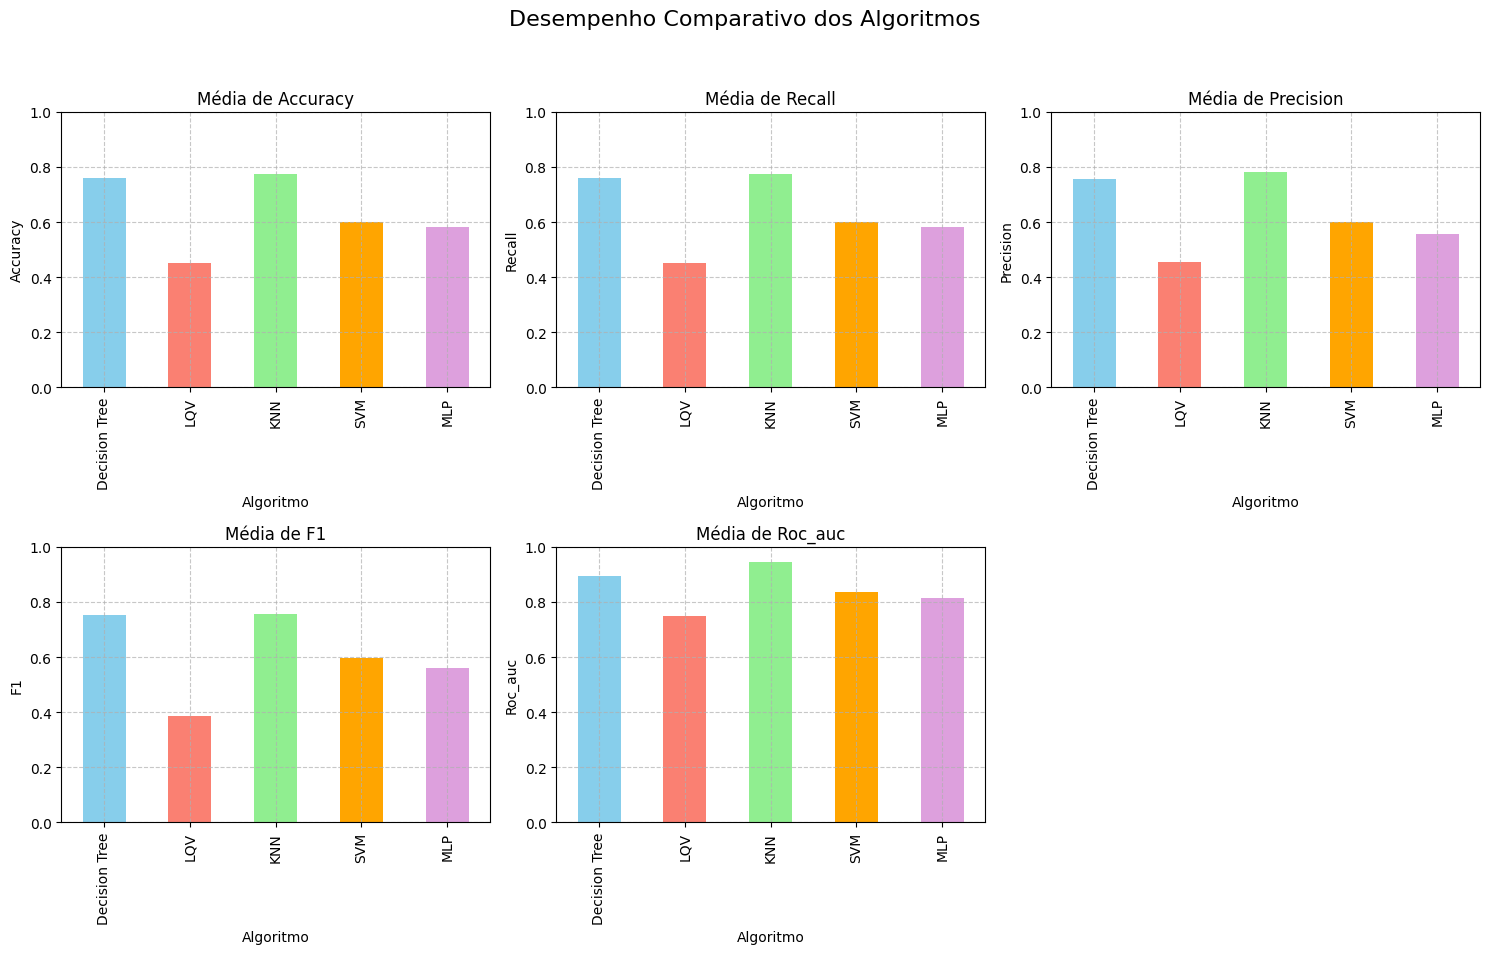

In [ ]:
metrics_means = {
    "Decision Tree": df_dt[['accuracy', 'recall', 'precision', 'f1', 'roc_auc']].mean(),
    "LQV": df_lqv[['accuracy', 'recall', 'precision', 'f1', 'roc_auc']].mean(),
    "KNN": df_knn[['accuracy', 'recall', 'precision', 'f1', 'roc_auc']].mean(),
    "SVM": df_svm[['accuracy', 'recall', 'precision', 'f1', 'roc_auc']].mean(),
    "MLP": df_mlp[['accuracy', 'recall', 'precision', 'f1', 'roc_auc']].mean()
}

metrics_df = pd.DataFrame(metrics_means).T
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Desempenho Comparativo dos Algoritmos', fontsize=16)

metrics = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']

for i, metric in enumerate(metrics):
    ax = axes[i // 3, i % 3]
    metrics_df[metric].plot(kind='bar', ax=ax, color=['skyblue', 'salmon', 'lightgreen', 'orange', 'plum'])
    ax.set_title(f'Média de {metric.capitalize()}')
    ax.set_xlabel('Algoritmo')
    ax.set_ylabel(metric.capitalize())
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.7)

axes[1, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()